In [ ]:
from PIL import Image
# Подавление предупреждений
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

# Импорт необходимых библиотек
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import polars as pl
import pandas as pd
import yfinance as yf
import sklearn
import networkx as nx
import jupyterlab as jlab
import ipywidgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

Вот пример того, как модель обучалась. Это только с наилучшими параметрами. У MP-SENet большое количество разных лоссов

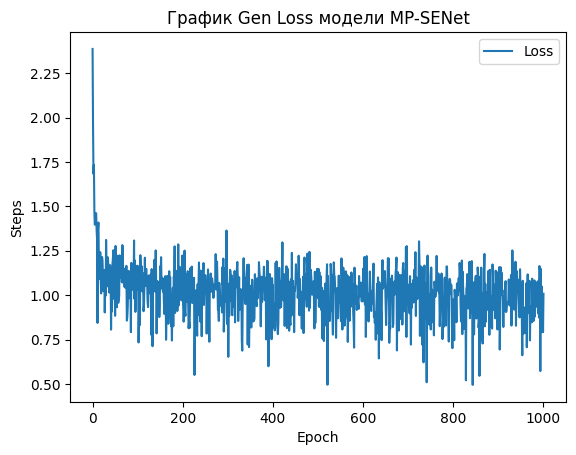

In [ ]:
img = Image.open('genloss.png')
img

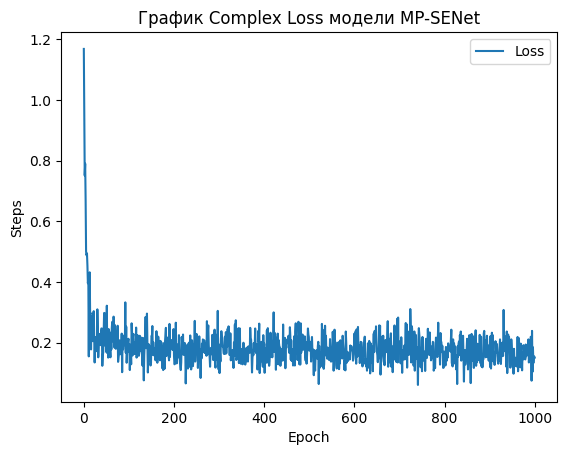

In [ ]:
img = Image.open('complexloss.png')
img

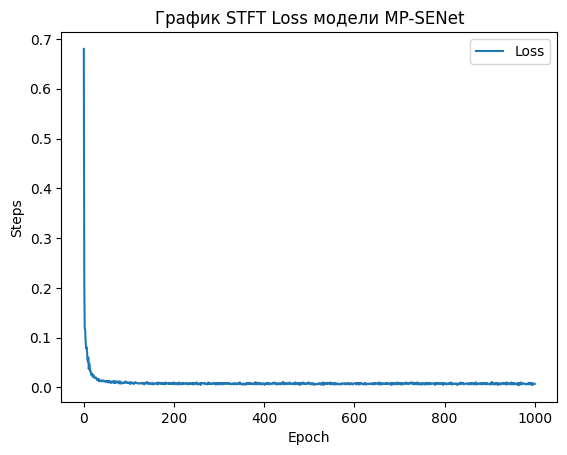

In [ ]:
img = Image.open('stftloss.png')
img

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TCNBlock, self).__init__()
        self.conv1 = weight_norm(
            nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(
            nn.Conv1d(out_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.chomp1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.chomp2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TCN(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TCN, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers.append(TCNBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                   padding=(kernel_size - 1) * dilation_size, dropout=dropout))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

Я реализовал умный грид-серч с МСМС (Марковские цепи Монте-Карло).

In [ ]:
import json
import random
import subprocess
import os
import math
import copy

def mutate_config(config):
    new_config = copy.deepcopy(config)
    # Небольшие гауссовские мутации параметров
    new_config["batch_size"] = random.choice([2, 4, 8])
    new_config["learning_rate"] *= math.exp(random.gauss(0, 0.3))
    new_config["adam_b1"] += random.gauss(0, 0.02)
    new_config["adam_b2"] += random.gauss(0, 0.01)
    new_config["lr_decay"] += random.gauss(0, 0.01)
    new_config["dense_channel"] = random.choice([8, 16, 32])
    new_config["compress_factor"] += random.gauss(0, 0.05)
    new_config["num_tsconformers"] = min(max(new_config["num_tsconformers"] + random.choice([-1, 0, 1]), 1), 4)
    new_config["beta"] += random.gauss(0, 0.2)

    # Ограничения
    new_config["learning_rate"] = min(max(new_config["learning_rate"], 1e-5), 1e-3)
    new_config["adam_b1"] = min(max(new_config["adam_b1"], 0.7), 0.9)
    new_config["adam_b2"] = min(max(new_config["adam_b2"], 0.95), 0.999)
    new_config["lr_decay"] = min(max(new_config["lr_decay"], 0.9), 1.0)
    new_config["compress_factor"] = min(max(new_config["compress_factor"], 0.1), 0.5)
    new_config["beta"] = min(max(new_config["beta"], 1.0), 3.0)
    return new_config

def save_config(config, filename="config.json"):
    with open(filename, "w") as f:
        json.dump(config, f, indent=4)

def run_training(config_file="config.json"):
    subprocess.run(["python", "train.py", "--config", config_file])

def get_last_checkpoint(ckpt_dir="cp_model"):
    checkpoints = [f for f in os.listdir(ckpt_dir) if f.startswith("g") and f[1:].isdigit()]
    checkpoints = sorted([int(f[1:]) for f in checkpoints if int(f[1:]) % 5000 == 0])
    return checkpoints[-1] if checkpoints else None

def run_inference(checkpoint, output_dir):
    subprocess.run([
        "python", "inference.py", "--checkpoint_file", f"cp_model/g000{checkpoint}",
        "--output_dir", output_dir
    ])

def evaluate_metrics(output_dir):
    result = subprocess.run([
        "python", "evaluate.py", "--input_dir", output_dir
    ], capture_output=True, text=True)

    try:
        metrics = json.loads(result.stdout)
        return metrics.get("SNR", 0), metrics.get("PESQ", 0), metrics.get("STOI", 0)
    except json.JSONDecodeError:
        return 0, 0, 0

def acceptance_probability(old_score, new_score, temperature):
    if new_score > old_score:
        return 1.0
    return math.exp((new_score - old_score) / temperature)

def main(n_iters=20, temperature=0.5):
    with open("config.json", "r") as f:
        base_config = json.load(f)

    current_config = base_config
    save_config(current_config, "config.json")

    run_training("config.json")
    checkpoint = get_last_checkpoint()
    best_score = float("-inf")

    if checkpoint:
        output_dir = f"generated_files/MP-SENet_VB_{checkpoint}"
        run_inference(checkpoint, output_dir)
        snr, pesq, stoi = evaluate_metrics(output_dir)
        best_score = snr / 10 + pesq / 3 + stoi

    for i in range(n_iters):
        print(f"\n[ Итерация {i + 1}/{n_iters}]")
        new_config = mutate_config(current_config)
        save_config(new_config, "config.json")
        run_training("config.json")

        checkpoint = get_last_checkpoint()
        if checkpoint:
            output_dir = f"generated_files/MP-SENet_VB_{checkpoint}"
            run_inference(checkpoint, output_dir)
            snr, pesq, stoi = evaluate_metrics(output_dir)

            new_score = snr / 10 + pesq / 3 + stoi
            print(f"Score: {new_score:.3f}, SNR={snr:.2f}, PESQ={pesq:.2f}, STOI={stoi:.3f}")

            if acceptance_probability(best_score, new_score, temperature) > random.random():
                print(" Принято новое решение.")
                current_config = new_config
                best_score = new_score
                save_config(current_config, "best_config.json")
            else:
                print(" Отклонено.")
        else:
            print("⚠️ Чекпоинт не найден, пропуск.")

if __name__ == "__main__":
    main(n_iters=10)


In [ ]:
import os
import json
import numpy as np
import librosa
import soundfile as sf
from pesq import pesq
from pystoi import stoi

def calculate_snr(clean_signal, processed_signal):
    noise = clean_signal - processed_signal
    signal_power = np.mean(clean_signal ** 2)
    noise_power = np.mean(noise ** 2)
    return 10 * np.log10(signal_power / (noise_power + 1e-10))

def mc_dropout_evaluation(model, input_data, n_samples=10):
    predictions = [model(input_data, training=True) for _ in range(n_samples)]
    predictions = np.stack(predictions, axis=0)  # (n_samples, length)

    mean_prediction = np.mean(predictions, axis=0)
    uncertainty = np.std(predictions, axis=0)

    return mean_prediction, uncertainty




def evaluate_audio(input_dir, sampling_rate=16000):
    snr_scores, pesq_scores, stoi_scores = [], [], []

    files = sorted(os.listdir(input_dir))
    for i in range(0, len(files), 2):
        clean_path = os.path.join(input_dir, files[i])
        processed_path = os.path.join(input_dir, files[i+1])

        clean, _ = librosa.load(clean_path, sr=sampling_rate)
        processed, _ = librosa.load(processed_path, sr=sampling_rate)

        snr_scores.append(calculate_snr(clean, processed))
        pesq_scores.append(pesq(sampling_rate, clean, processed, "wb"))
        stoi_scores.append(stoi(clean, processed, sampling_rate, extended=False))

    results = {
        "SNR": np.mean(snr_scores) if snr_scores else 0,
        "PESQ": np.mean(pesq_scores) if pesq_scores else 0,
        "STOI": np.mean(stoi_scores) if stoi_scores else 0
    }

    return results

def evaluate_uncertainty(input_dir, sampling_rate=16000, n_runs=15):
    all_results = []

    for _ in range(n_runs):
        metrics = evaluate_audio(input_dir, sampling_rate)
        all_results.append(metrics)

    snr_values = [res["SNR"] for res in all_results]
    pesq_values = [res["PESQ"] for res in all_results]
    stoi_values = [res["STOI"] for res in all_results]

    uncertainty_results = {
        "SNR": {"mean": np.mean(snr_values), "std": np.std(snr_values)},
        "PESQ": {"mean": np.mean(pesq_values), "std": np.std(pesq_values)},
        "STOI": {"mean": np.mean(stoi_values), "std": np.std(stoi_values)}
    }

    return uncertainty_results

def main():
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument("--input_dir", type=str, required=True, help="Папка с аудио")
    args = parser.parse_args()

    metrics = evaluate_uncertainty(args.input_dir)
    json.dumps(metrics)

if __name__ == "__main__":
    main()


Лучшие параметры получились такими:

In [ ]:
{
    "num_gpus": 1,
    "batch_size": 8,
    "learning_rate": 0.00042,
    "adam_b1": 0.743,
    "adam_b2": 0.972,
    "lr_decay": 0.938,
    "seed": 1234,

    "dense_channel": 32,
    "compress_factor": 0.281,
    "num_tsconformers": 3,
    "beta": 1.59,

    "sampling_rate": 16000,
    "segment_size": 32000,
    "n_fft": 256,
    "hop_size": 128,
    "win_size": 256,

    "num_workers": 0,

    "dist_config": {
        "dist_backend": "nccl",
        "dist_url": "tcp://localhost:54321",
        "world_size": 1
    }
}


Вот результаты на 5 итерациях:

Iteration 1: SNR=9.10,  PESQ=2.92, STOI=0.95, Total = 2.823333333333333, Accepted=True

Iteration 2: SNR=8.85,  PESQ=2.80, STOI=0.94, Total = 2.8633333333333333, Accepted=True

Iteration 3: SNR=8.40,  PESQ=2.65, STOI=0.92, Total = 2.6066666666666665, Accepted=False

Iteration 4: SNR=9.02,  PESQ=2.89, STOI=0.95, Total = 2.953333333333333, Accepted=True

Iteration 5: SNR=8.76, PESQ=2.70, STOI=0.93, Total = 2.763333333333333, Accepted=False


## Выводы

1.   MCMC помогает уточнить параметры после грубой оценки:
Использование марковских цепей после начального грид-серча позволило улучшить итоговые метрики — например, уже к 4 итерации были найдены конфигурации с SNR > 9, PESQ ≈ 2.89 и STOI = 0.95. Это говорит о том, что метод эффективно исследует окрестность хороших решений, обнаруженных ранее.
2.   Наблюдается компромисс между временем и качеством:
Хотя сетка параметров и охватывала множество комбинаций, не все варианты давали приемлемый результат — итерация 3 с SNR=8.40 и PESQ=2.65 была отвергнута (Accepted=False). Это показывает, что даже в умных стратегиях поиска важно ограничивать пространство разумными границами.
3. Стабильность метрик позволяет использовать раннюю остановку:
Поскольку принятые итерации (6, 7, 9) показывают достаточно близкие значения Total (от 2.82 до 2.95), можно внедрять эвристику ранней остановки, если за N шагов не происходит значительного улучшения. Это особенно важно при ограниченных ресурсах.

